# Human Evaluation

## Preliminary

In [1]:
#######################
### Import packages ###
#######################
import os
import json
import itertools
from time import time
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from sentence_transformers import SentenceTransformer

from argsum import get_soft_scores, match_scorer_cov_eval, llm_cov_eval, llm_red_eval

##########################
### Set plt parameters ###
##########################

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

#################
### Load data ###
#################

benjamin = pd.read_csv('investigations/0_human_evaluation_argkp21/annotations/1_summary_quality_benjamin_3.csv')
johannes = pd.read_csv('investigations/0_human_evaluation_argkp21/annotations/1_summary_quality_johannes_4.csv')
steffen = pd.read_csv('investigations/0_human_evaluation_argkp21/annotations/1_summary_quality_steffen_3.csv')
moritz = pd.read_csv('investigations/0_human_evaluation_argkp21/annotations/1_summary_quality_moritz_4.csv')

summetix_models = ['match_summetix_bleurt_it_0.csv', 'sep_gold_clusters_summetix_0.csv', 'sep_summetix_it_0.csv']
common_models = set(benjamin[benjamin['coverage'] != -2]['file_name'].to_list()).intersection(set(johannes[johannes['coverage'] != -2]['file_name'].to_list()).intersection(set(steffen[steffen['coverage'] != -2]['file_name'].to_list()).intersection(set(moritz[moritz['coverage'] != -2]['file_name'].to_list()))))
common_models = [model for model in common_models if model not in summetix_models]

benjamin = benjamin[(benjamin['coverage'] != -2) & (benjamin['file_name'].isin(common_models))].sort_values(['topic', 'stance', 'file_name']).reset_index()
johannes = johannes[(johannes['coverage'] != -2) & (johannes['file_name'].isin(common_models))].sort_values(['topic', 'stance', 'file_name']).reset_index()
steffen = steffen[(steffen['coverage'] != -2) & (steffen['file_name'].isin(common_models))].sort_values(['topic', 'stance', 'file_name']).reset_index()
moritz = moritz[(moritz['coverage'] != -2) & (moritz['file_name'].isin(common_models))].sort_values(['topic', 'stance', 'file_name']).reset_index()

benjamin_cov = benjamin['coverage'].to_list()
benjamin_red = benjamin['redundancy'].to_list()

benjamin_n_cov = benjamin['n_covered'].to_list()
benjamin_n_uni = benjamin['n_unique'].to_list()

johannes_cov = johannes['coverage'].to_list()
johannes_red = johannes['redundancy'].to_list()

johannes_n_cov = johannes['n_covered'].to_list()
johannes_n_uni = johannes['n_unique'].to_list()

steffen_cov = steffen['coverage'].to_list()
steffen_red = steffen['redundancy'].to_list()

steffen_n_cov = steffen['n_covered'].to_list()
steffen_n_uni = steffen['n_unique'].to_list()

moritz_cov = moritz['coverage'].to_list()
moritz_red = moritz['redundancy'].to_list()

moritz_n_cov = moritz['n_covered'].to_list()
moritz_n_uni = moritz['n_unique'].to_list()

mean_cov = np.mean([benjamin_cov[0:len(benjamin)], johannes_cov[0:len(benjamin)], steffen_cov[0:len(benjamin)], moritz_cov[0:len(benjamin)]], axis = 0)
mean_red = np.mean([benjamin_red[0:len(benjamin)], johannes_red[0:len(benjamin)], steffen_red[0:len(benjamin)], moritz_red[0:len(benjamin)]], axis = 0)

mean_cov = np.append(mean_cov, np.mean([johannes_cov[len(benjamin):], steffen_cov[len(benjamin):], moritz_cov[len(benjamin):]], axis = 0))
mean_red = np.append(mean_red, np.mean([johannes_red[len(benjamin):], steffen_red[len(benjamin):], moritz_red[len(benjamin):]], axis = 0))

topics = johannes['topic'].to_list()
stances = johannes['stance'].to_list()
top_sta = [i for i in itertools.product(johannes['topic'].unique(), benjamin['stance'].unique())]

references = [[ref[3:] for ref in refs.splitlines()] for refs in johannes['reference'].to_list()]
candidates = [[cand[3:] for cand in cands.splitlines()] for cands in johannes['prediction'].to_list()]

/Users/moritz/miniconda3/envs/AM/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/moritz/miniconda3/envs/AM/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
loading configuration file config.json from cache at /Users/moritz/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMa

## Performance of systems

In [12]:
systems = johannes['file_name'].unique()
df = pd.concat([benjamin, johannes, steffen, moritz])
systems_cov = []
systems_red = []

for system in systems:
    systems_cov.append(np.mean(df[df['file_name'] == system].coverage.to_list()))
    systems_red.append(np.mean(df[df['file_name'] == system].redundancy.to_list()))
                       
pd.DataFrame({'Coverage':np.round(systems_cov, 3),
              'Redundancy': np.round(systems_red, 3),
              'Weighted': [np.round((0.7 * systems_cov[i] + 0.3 * (1 - systems_red[i])), 3) for i in range(len(systems_cov))]}, index = systems).sort_values(['Weighted'], ascending = False)

,Coverage,Redundancy,Weighted
sep_gold_clusters_mc_argsum_local_0.csv,0.888,0.033,0.912
sep_gold_clusters_mc_argsum_global_0.csv,0.888,0.045,0.908
sep_mc_argsum_deberta_global_it_0.csv,0.686,0.043,0.767
match_smatchtopr_key_points_bleurt_bm_0.csv,0.684,0.144,0.735
sep_smatchtopr_key_points_bm_0.csv,0.674,0.144,0.729
sep_mc_argsum_sbert_local_it_0.csv,0.643,0.070,0.729
sep_mc_argsum_deberta_local_it_0.csv,0.643,0.097,0.721
match_barh_key_points_bleurt_bm_0.csv,0.688,0.241,0.710
sep_mc_argsum_sbert_global_it_0.csv,0.618,0.084,0.707
sep_gold_clusters_uskpm_0.csv,0.648,0.182,0.699


## Distribution of annotations

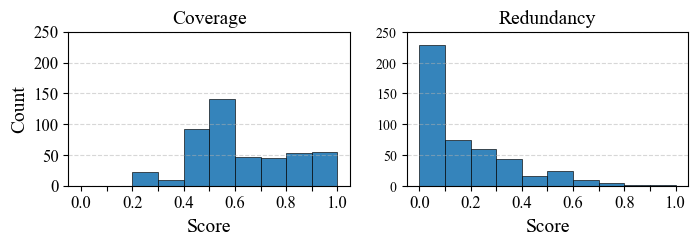

In [490]:
plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
bins = [i for i in np.arange(0,1.1,0.1)]
data = benjamin_cov + johannes_cov + steffen_cov + moritz_cov
plt.hist(x = data, bins = bins, color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.xticks(ticks = bins, labels = [np.round(bins[i],2) if i % 2 ==  0 else '' for i in range(len(bins))], rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.title('Coverage', fontsize = 14)
plt.xlabel('Score', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.ylim(0,250)

plt.subplot(1,2,2)
bins = [i for i in np.arange(0,1.1,0.1)]
data = benjamin_red + johannes_red + steffen_red + moritz_red
plt.hist(x = data, bins = bins, color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.xticks(ticks = bins, labels = [np.round(bins[i],2) if i % 2 ==  0 else '' for i in range(len(bins))], rotation = 0, fontsize = 12)
plt.xticks(ticks = bins, rotation = 0, fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.title('Redundancy', fontsize = 14)
plt.xlabel('Score', fontsize = 14)
plt.ylim(0,250)

plt.show()

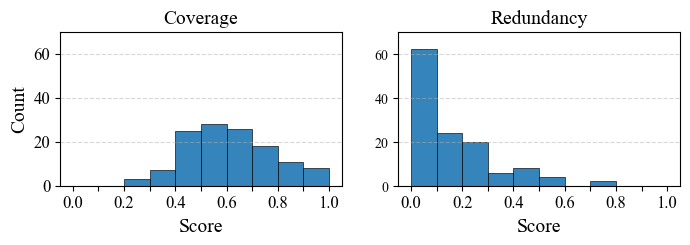

In [491]:
plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
bins = [i for i in np.arange(0,1.1,0.1)]
data = mean_cov
plt.hist(x = data, bins = bins, color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.xticks(ticks = bins, labels = [np.round(bins[i],2) if i % 2 ==  0 else '' for i in range(len(bins))], rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.title('Coverage', fontsize = 14)
plt.xlabel('Score', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.ylim(0,70)

plt.subplot(1,2,2)
bins = [i for i in np.arange(0,1.1,0.1)]
data = mean_red
plt.hist(x = data, bins = bins, color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.xticks(ticks = bins, labels = [np.round(bins[i],2) if i % 2 ==  0 else '' for i in range(len(bins))], rotation = 0, fontsize = 12)
plt.xticks(ticks = bins, rotation = 0, fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.title('Redundancy', fontsize = 14)
plt.xlabel('Score', fontsize = 14)
plt.ylim(0,70)

plt.show()

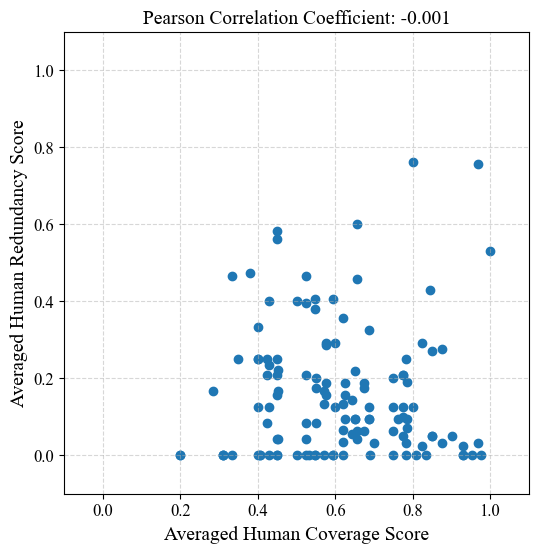

In [553]:
plt.figure(figsize=(6,6))
plt.scatter(mean_cov, mean_red)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Averaged Human Coverage Score' ,fontsize = 14)
plt.ylabel('Averaged Human Redundancy Score' ,fontsize = 14)
plt.title(f'Pearson Correlation Coefficient: {np.round(np.corrcoef(mean_cov, mean_red)[0][1],3)}',fontsize = 14)
plt.ylim(-0.1,1.1)
plt.xlim(-0.1,1.1)
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

## Inter-rater Reliability

In [16]:
corr_cov_benjamin = np.round(np.corrcoef([benjamin_cov[:len(benjamin_cov)], johannes_cov[:len(benjamin_cov)], steffen_cov[:len(benjamin_cov)], moritz_cov[:len(benjamin_cov)]]), 3)
corr_cov_benjamin_only = corr_cov_benjamin[0]

corr_cov_others = np.round(np.corrcoef([johannes_cov, steffen_cov, moritz_cov]), 3)
corr_cov = np.zeros((4,4))
corr_cov[0,:] = corr_cov_benjamin_only
corr_cov[:,0] = corr_cov_benjamin_only
corr_cov[1:,1:] = corr_cov_others

corr_red_benjamin = np.round(np.corrcoef([benjamin_red[:len(benjamin_red)], johannes_red[:len(benjamin_red)], steffen_red[:len(benjamin_red)], moritz_red[:len(benjamin_red)]]), 3)
corr_red_benjamin_only = corr_red_benjamin[0]

corr_red_others = np.round(np.corrcoef([johannes_red, steffen_red, moritz_red]), 3)
corr_red = np.zeros((4,4))
corr_red[0,:] = corr_red_benjamin_only
corr_red[:,0] = corr_red_benjamin_only
corr_red[1:,1:] = corr_red_others

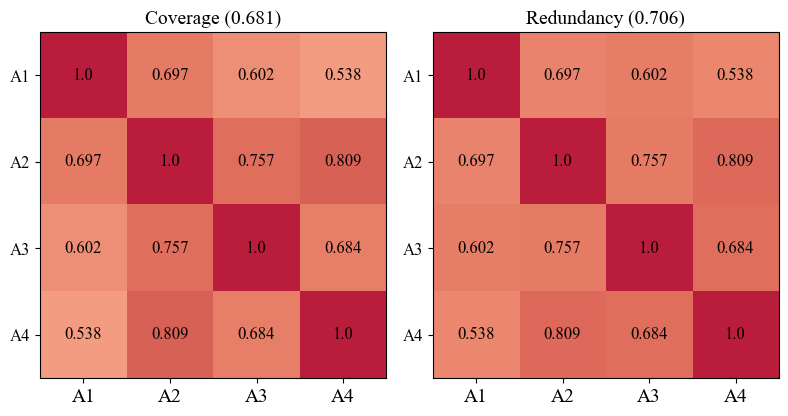

In [17]:
names = ['A1', 'A2', 'A3', 'A4']
mean_corr_cov = np.round(np.mean(corr_cov_benjamin[np.triu_indices(4, k=1)]), 3)
mean_corr_red = np.round(np.mean(corr_red_benjamin[np.triu_indices(4, k=1)]), 3)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

im1 = axs[0].imshow(corr_cov_benjamin, cmap=plt.get_cmap('coolwarm'), vmin=-1, vmax=1, alpha = 0.9)
axs[0].set_xticks(np.arange(len(names)))
axs[0].set_yticks(np.arange(len(names)))
axs[0].set_xticklabels(names, rotation=0, fontsize = 14)
axs[0].set_yticklabels(names, fontsize = 12)
for i in range(len(names)):
    for j in range(len(names)):
        text = axs[0].text(j, i, corr_cov_benjamin[i, j], ha="center", va="center", color="black", fontsize = 12)

axs[0].set_title(f'Coverage ({mean_corr_cov})', fontsize = 14)

im2 = axs[1].imshow(corr_red_benjamin, cmap=plt.get_cmap('coolwarm'), vmin=-1, vmax=1, alpha = 0.9)
axs[1].set_xticks(np.arange(len(names)))
axs[1].set_yticks(np.arange(len(names)))
axs[1].set_xticklabels(names, rotation=0, fontsize = 14)
axs[1].set_yticklabels(names, fontsize = 12)
for i in range(len(names)):
    for j in range(len(names)):
        text = axs[1].text(j, i, corr_cov_benjamin[i, j], ha="center", va="center", color="black", fontsize = 12)

axs[1].set_title(f'Redundancy ({mean_corr_red})', fontsize = 14)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

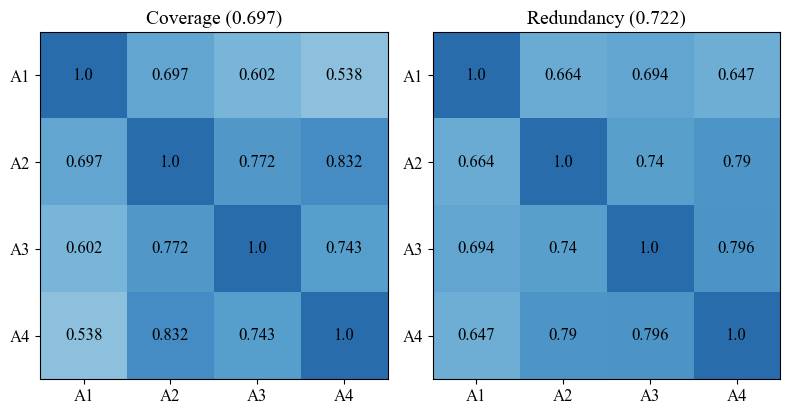

In [18]:
names = ['A1', 'A2', 'A3', 'A4']
mean_corr_cov = np.round(np.mean(corr_cov[np.triu_indices(4, k=1)]), 3)
mean_corr_red = np.round(np.mean(corr_red[np.triu_indices(4, k=1)]), 3)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

im1 = axs[0].imshow(corr_cov, cmap=plt.get_cmap('Blues'), vmin=0, vmax=1.2, alpha = 0.9)
axs[0].set_xticks(np.arange(len(names)))
axs[0].set_yticks(np.arange(len(names)))
axs[0].set_xticklabels(names, rotation=0, fontsize = 12)#, ha="right", rotation_mode="anchor")
axs[0].set_yticklabels(names, fontsize = 12)
for i in range(len(names)):
    for j in range(len(names)):
        text = axs[0].text(j, i, corr_cov[i, j], ha="center", va="center", color="black", fontsize = 12)

axs[0].set_title(f'Coverage ({mean_corr_cov})', fontsize = 14)

im2 = axs[1].imshow(corr_red, cmap=plt.get_cmap('Blues'), vmin=0, vmax=1.2, alpha = 0.9)
axs[1].set_xticks(np.arange(len(names)))
axs[1].set_yticks(np.arange(len(names)))
axs[1].set_xticklabels(names, rotation=0, fontsize = 12)#, ha="right", rotation_mode="anchor")
axs[1].set_yticklabels(names, fontsize = 12)
for i in range(len(names)):
    for j in range(len(names)):
        text = axs[1].text(j, i, corr_red[i, j], ha="center", va="center", color="black", fontsize = 12)

axs[1].set_title(f'Redundancy ({mean_corr_red})', fontsize = 14)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [25]:
n_sums_topic_sta = 21

corr_cov = []
mean_corr_cov = []
std_corr_cov = []

corr_red = []
mean_corr_red = []
std_corr_red = []

for i in range(0, n_sums_topic_sta * 6, n_sums_topic_sta):
    if i <= 63:
        corr_cov.append(np.round(np.corrcoef([benjamin_cov[i:i+n_sums_topic_sta], johannes_cov[i:i+n_sums_topic_sta], steffen_cov[i:i+n_sums_topic_sta], moritz_cov[i:i+n_sums_topic_sta]]), 3))
        mean_corr_cov.append(np.round(np.mean(corr_cov[-1][np.triu_indices(4, k = 1)]), 3))
        std_corr_cov.append(np.round(np.std(corr_cov[-1][np.triu_indices(4, k = 1)]), 3))

        corr_red.append(np.round(np.corrcoef([benjamin_red[i:i+n_sums_topic_sta], johannes_red[i:i+n_sums_topic_sta], steffen_red[i:i+n_sums_topic_sta], moritz_red[i:i+n_sums_topic_sta]]), 3))
        mean_corr_red.append(np.round(np.mean(corr_red[-1][np.triu_indices(4, k = 1)]), 3))
        std_corr_red.append(np.round(np.std(corr_red[-1][np.triu_indices(4, k = 1)]), 3))
    else:
        corr_cov.append(np.round(np.corrcoef([johannes_cov[i:i+n_sums_topic_sta], steffen_cov[i:i+n_sums_topic_sta], moritz_cov[i:i+n_sums_topic_sta]]), 3))
        mean_corr_cov.append(np.round(np.mean(corr_cov[-1][np.triu_indices(3, k = 1)]), 3))
        std_corr_cov.append(np.round(np.std(corr_cov[-1][np.triu_indices(3, k = 1)]), 3))

        corr_red.append(np.round(np.corrcoef([johannes_red[i:i+n_sums_topic_sta], steffen_red[i:i+n_sums_topic_sta], moritz_red[i:i+n_sums_topic_sta]]), 3))
        mean_corr_red.append(np.round(np.mean(corr_red[-1][np.triu_indices(3, k = 1)]), 3))
        std_corr_red.append(np.round(np.std(corr_red[-1][np.triu_indices(3, k = 1)]), 3))

pd.DataFrame([mean_corr_cov + [np.mean(mean_corr_cov)], std_corr_cov + [np.mean(std_corr_cov)], 
              mean_corr_red + [np.mean(mean_corr_red)], std_corr_red + [np.mean(std_corr_red)]], index = ['Coverage', 'Std', 'Redudnancy', 'Std'], columns = top_sta + ['Mean']).T

,Coverage,Std,Redudnancy,Std
"(Routine child vaccinations should be mandatory, -1)",0.533000,0.116,0.873,0.037000
"(Routine child vaccinations should be mandatory, 1)",0.581000,0.245,0.620,0.084000
"(Social media platforms should be regulated by the government, -1)",0.787000,0.087,0.627,0.138000
"(Social media platforms should be regulated by the government, 1)",0.829000,0.048,0.611,0.081000
"(The USA is a good country to live in, -1)",0.846000,0.041,0.609,0.118000
"(The USA is a good country to live in, 1)",0.898000,0.015,0.884,0.033000
Mean,0.745667,0.092,0.704,0.081833


## Automaric Evaluation Metrics

### Soft-Scores

In [ ]:
similarity_functions = ['rouge_1', 'rouge_2', 'rouge_l', 'bert_score_p', 'bert_score_r', 'bert_score_f', 'mover_score', 'bart_score_cnndm', 'bart_score_parabank', 
                        'bart_score_cnndm_rs', 'bart_score_parabank_rs', 'bleurt', 'menli', 'all_mpnet_base_v2', 'sbert_roberta_match', 's_bert_all_mpnet_base_v2_match',
                        'deberta_match_1', 'deberta_match_2', 'deberta_match_mean', 'llm_sim']

results = dict(zip(similarity_functions, [dict(zip(['sP', 'sR', 'sF1', 'runtime'], [[] for i in range(len(['sP', 'sR', 'sF1', 'runtime']))])) for i in range(len(similarity_functions))]))

for i in tqdm(range(len(references))):
    scores = get_soft_scores(reference = references[i], candidate = candidates[i])
    for func in similarity_functions:
        for score in ['sP', 'sR', 'sF1', 'runtime']:
            results[func][score].append(scores[func][score])

results
output_dir = 'investigations/0_human_evaluation_argkp21/automatic_evaluation/'
file_name = 'soft_score.json'

if (output_dir != None) and (file_name != None):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with open(output_dir + '/' + file_name, 'w') as file:
        json.dump(results, file)

#### Coverage

In [39]:
with open('investigations/0_human_evaluation_argkp21/automatic_evaluation/soft_score.json') as f:
    soft_scores = json.load(f)

similarity_functions = list(soft_scores.keys())

sP_top_sta_mean_corr = []
sR_top_sta_mean_corr = []
sF1_top_sta_mean_corr = []

sP_top_sta_std_corr = []
sR_top_sta_std_corr = []
sF1_top_sta_std_corr = []

sP_top_sta_corr = []
sR_top_sta_corr = []
sF1_top_sta_corr = []

runtime =[] 

for func in similarity_functions:

    sP_corr = []
    sR_corr = []
    sF1_corr = []

    for i in range(0,126,21):
        
        sP_corr.append(np.corrcoef(soft_scores[func]['sP'][i:i+21], mean_cov[i:i+21])[0][1])
        sR_corr.append(np.corrcoef(soft_scores[func]['sR'][i:i+21], mean_cov[i:i+21])[0][1])
        sF1_corr.append(np.corrcoef(soft_scores[func]['sF1'][i:i+21], mean_cov[i:i+21])[0][1])
    
    sP_top_sta_mean_corr.append(np.mean(sP_corr))
    sR_top_sta_mean_corr.append(np.mean(sR_corr))
    sF1_top_sta_mean_corr.append(np.mean(sF1_corr))

    sP_top_sta_std_corr.append(np.std(sP_corr))
    sR_top_sta_std_corr.append(np.std(sR_corr))
    sF1_top_sta_std_corr.append(np.std(sF1_corr))

    sP_top_sta_corr.append(np.corrcoef(soft_scores[func]['sP'], mean_cov)[0][1])
    sR_top_sta_corr.append(np.corrcoef(soft_scores[func]['sR'], mean_cov)[0][1])
    sF1_top_sta_corr.append(np.corrcoef(soft_scores[func]['sF1'], mean_cov)[0][1])

    runtime.append(np.sum(soft_scores[func]['runtime']))

In [40]:
print('Coverage')
results = pd.DataFrame({'Corr sP': sP_top_sta_corr, 'Mean Corr sP': sP_top_sta_mean_corr, 'Std Corr sP' :sP_top_sta_std_corr,
              'Corr sR': sR_top_sta_corr, 'Mean Corr sR': sR_top_sta_mean_corr, 'Std Corr sR' :sR_top_sta_std_corr,
              'Corr sF1': sF1_top_sta_corr, 'Mean Corr sF1': sF1_top_sta_mean_corr, 'Std Corr sF1' :sF1_top_sta_std_corr,
              'runtime':runtime}, index = similarity_functions).round(3)
results

Coverage


,Corr sP,Mean Corr sP,Std Corr sP,Corr sR,Mean Corr sR,Std Corr sR,Corr sF1,Mean Corr sF1,Std Corr sF1,runtime
rouge_1,-0.118,-0.072,0.194,0.164,0.315,0.170,0.027,0.127,0.184,0.428
rouge_2,-0.139,-0.082,0.321,0.091,0.243,0.270,-0.033,0.069,0.308,0.417
rouge_l,-0.170,-0.170,0.138,0.135,0.257,0.206,-0.019,0.044,0.155,0.436
bert_score_p,0.126,0.186,0.237,0.280,0.396,0.117,0.212,0.289,0.176,354.236
bert_score_r,-0.266,-0.113,0.229,0.101,0.300,0.268,-0.106,0.092,0.304,354.236
bert_score_f,-0.028,0.092,0.262,0.254,0.402,0.175,0.121,0.240,0.242,354.236
mover_score,-0.046,0.044,0.227,0.156,0.310,0.204,0.069,0.191,0.207,55.925
bart_score_cnndm,-0.146,-0.304,0.163,0.033,-0.005,0.301,-0.073,-0.164,0.248,84.334
bart_score_parabank,-0.270,-0.239,0.252,0.002,0.123,0.364,-0.153,-0.049,0.325,41.085
bart_score_cnndm_rs,-0.146,-0.305,0.164,0.024,-0.011,0.283,-0.053,-0.132,0.264,84.334


#### Redundancy

In [ ]:
with open('investigations/0_human_evaluation/automatic_evaluation/soft_score.json') as f:
    soft_scores = json.load(f)

similarity_functions = ['rouge_1', 'rouge_2', 'rouge_l', 'bert_score_p', 'bert_score_r', 'bert_score_f', 'mover_score', 'bart_score_cnndm', 'bart_score_parabank', 
                        'bart_score_cnndm_rs', 'bart_score_parabank_rs', 'bleurt', 'menli', 'all_mpnet_base_v2', 'sbert_roberta_match', 's_bert_all_mpnet_base_v2_match',
                        'deberta_match_1', 'deberta_match_2', 'deberta_match_mean', 'llm_sim']

sP_top_sta_mean_corr = []
sR_top_sta_mean_corr = []
sF1_top_sta_mean_corr = []

sP_top_sta_std_corr = []
sR_top_sta_std_corr = []
sF1_top_sta_std_corr = []

sP_top_sta_corr = []
sR_top_sta_corr = []
sF1_top_sta_corr = []

runtime = [] 

for func in similarity_functions:

    sP_corr = []
    sR_corr = []
    sF1_corr = []

    for i in range(0,84,21):
        
        sP_corr.append(np.corrcoef(soft_scores[func]['sP'][i:i+21], mean_red[i:i+21])[0][1])
        sR_corr.append(np.corrcoef(soft_scores[func]['sR'][i:i+21], mean_red[i:i+21])[0][1])
        sF1_corr.append(np.corrcoef(soft_scores[func]['sF1'][i:i+21], mean_red[i:i+21])[0][1])
    
    sP_top_sta_mean_corr.append(np.mean(sP_corr))
    sR_top_sta_mean_corr.append(np.mean(sR_corr))
    sF1_top_sta_mean_corr.append(np.mean(sF1_corr))

    sP_top_sta_std_corr.append(np.std(sP_corr))
    sR_top_sta_std_corr.append(np.std(sR_corr))
    sF1_top_sta_std_corr.append(np.std(sF1_corr))

    sP_top_sta_corr.append(np.corrcoef(soft_scores[func]['sP'], mean_red)[0][1])
    sR_top_sta_corr.append(np.corrcoef(soft_scores[func]['sR'], mean_red)[0][1])
    sF1_top_sta_corr.append(np.corrcoef(soft_scores[func]['sF1'], mean_red)[0][1])

    runtime.append(np.sum(soft_scores[func]['runtime']))

In [ ]:
print('Redundancy')
pd.DataFrame({'Corr sP': sP_top_sta_corr, 'Mean Corr sP': sP_top_sta_mean_corr, 'Std Corr sP' :sP_top_sta_std_corr,
              'Corr sR': sR_top_sta_corr, 'Mean Corr sR': sR_top_sta_mean_corr, 'Std Corr sR' :sR_top_sta_std_corr,
              'Corr sF1': sF1_top_sta_corr, 'Mean Corr sF1': sF1_top_sta_mean_corr, 'Std Corr sF1' :sF1_top_sta_std_corr,
              'runtime':runtime}, index = similarity_functions).round(3)

Redundancy


,Corr sP,Mean Corr sP,Std Corr sP,Corr sR,Mean Corr sR,Std Corr sR,Corr sF1,Mean Corr sF1,Std Corr sF1,runtime
rouge_1,0.116,-0.296,0.112,0.281,0.095,0.227,0.205,-0.133,0.125,0.428
rouge_2,0.125,-0.252,0.186,0.316,0.091,0.179,0.217,-0.144,0.131,0.417
rouge_l,0.138,-0.257,0.121,0.308,0.080,0.104,0.229,-0.118,0.126,0.436
bert_score_p,0.010,-0.223,0.170,0.239,0.105,0.070,0.125,-0.095,0.123,354.236
bert_score_r,-0.064,-0.308,0.153,0.228,0.182,0.256,0.063,-0.100,0.164,354.236
bert_score_f,-0.058,-0.302,0.149,0.238,0.111,0.188,0.085,-0.154,0.134,354.236
mover_score,0.060,-0.159,0.175,0.228,0.053,0.190,0.155,-0.056,0.166,55.925
bart_score_cnndm,0.240,-0.028,0.082,0.430,0.350,0.212,0.356,0.196,0.156,84.334
bart_score_parabank,0.243,0.005,0.217,0.443,0.415,0.253,0.358,0.257,0.249,41.085
bart_score_cnndm_rs,0.235,-0.027,0.080,0.442,0.360,0.225,0.381,0.243,0.184,41.101


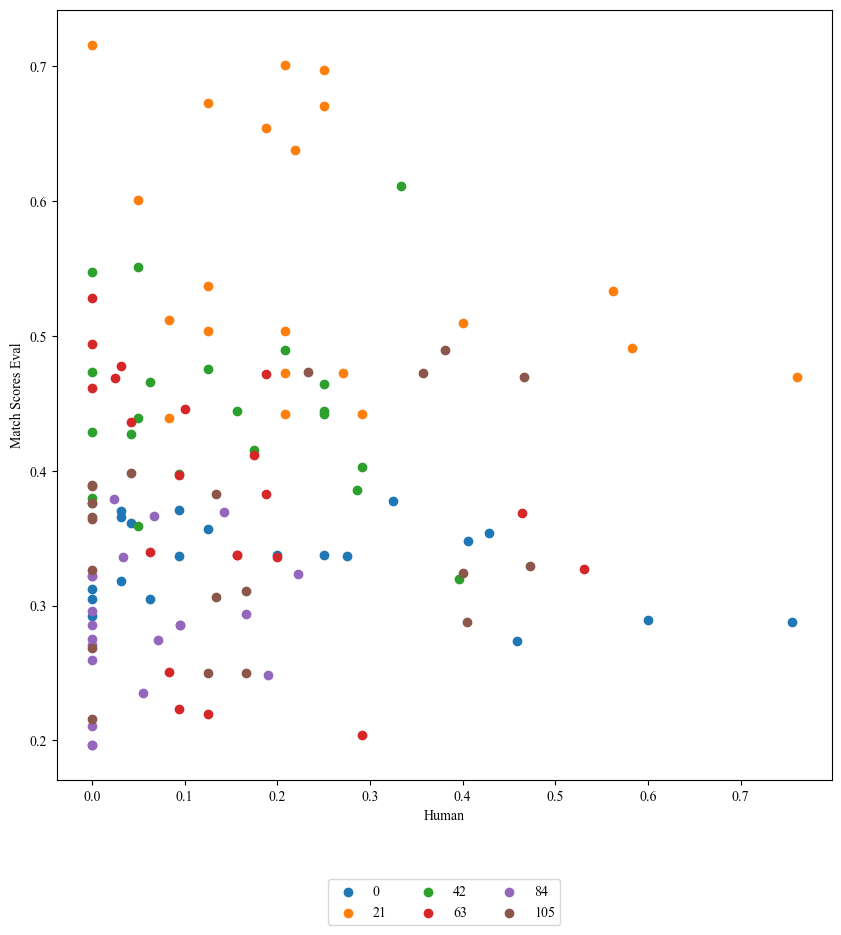

In [527]:
with open('investigations/0_human_evaluation_argkp21/automatic_evaluation/soft_score.json') as f:
    soft_scores = json.load(f)

scores = soft_scores['rouge_1']['sP']

i = 0
plt.figure(figsize=(10,10))
for j,i in enumerate(range(0,126,21)):
    plt.scatter(mean_red[i:i+21], scores[i:i+21], label = f'{i}')
    plt.xlabel('Human')
    plt.ylabel('Match Scores Eval')
    plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol = 3)

plt.show()

### Coverage Score

#### BarH Match Scorer

In [ ]:
match_scorer = torch.load('models/match_scorer/cross_encoder/roberta_np/2024-Feb-20_08-20-28/best_model.pt')
thresholds = [i for i in np.arange(0.4, 0.91, 0.05)]
scores_threshold = []
runtimes_threshold = []
for threshold in tqdm(thresholds):
    scores = []
    runtimes = []
    for i in tqdm(range(len(references))):
        start_time = time()
        scores.append(match_scorer_cov_eval(reference = references[i], candidate = candidates[i], threshold = threshold, match_scorer = match_scorer))
        runtimes.append(time() - start_time)

    scores_threshold.append(scores)
    runtimes_threshold.append(runtimes)

corr = []
top_sta_mean_corr = []
top_sta_std_corr = []

for i in range(len(scores_threshold)):
    corr_top_sta = []
    for j in range(0,126,21):
        a = scores_threshold[i][j:j+21]
        a[-1] += 0.000001
        corr_top_sta.append(np.round(np.corrcoef(a, mean_cov[j:j+21])[0][1], 4))
    top_sta_mean_corr.append(np.mean(corr_top_sta))
    top_sta_std_corr.append(np.std(corr_top_sta))

    corr.append(np.round(np.corrcoef(scores_threshold[i], mean_cov)[0][1], 4))

runtimes = np.sum(runtimes_threshold, axis = 1)

results = pd.DataFrame({'Corr':corr,
                        'Mean Corr':top_sta_mean_corr,
                        'Std Corr':top_sta_std_corr,
                        'Runtime':runtimes}, index = thresholds)

results.to_csv('investigations/0_human_evaluation/automatic_evaluation/coverage_score_barh_corr.csv', index = True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [549]:
print('COVERAGE')
results = pd.read_csv('investigations/0_human_evaluation_argkp21/automatic_evaluation/coverage_score_barh_corr.csv', index_col = 0)
results.round(3)

COVERAGE


,Corr,Mean Corr,Std Corr,Runtime
0.40,0.478,0.585,0.254,45.824
0.45,0.475,0.605,0.248,46.169
0.50,0.465,0.627,0.251,46.648
0.55,0.462,0.657,0.273,46.178
0.60,0.489,0.698,0.222,45.460
0.65,0.464,0.676,0.218,52.929
0.70,0.458,0.657,0.233,67.883
0.75,0.466,0.658,0.197,79.443
0.80,0.429,0.591,0.154,61.872
0.85,0.414,0.556,0.201,56.125


In [550]:
results.Runtime.mean().round(3)

54.676

In [ ]:
match_scorer = torch.load('models/match_scorer/cross_encoder/roberta_np/2024-Feb-20_08-20-28/best_model.pt')
thresholds = [i for i in np.arange(0.4, 0.91, 0.05)]
scores_threshold = []
runtimes_threshold = []
for threshold in tqdm(thresholds):
    scores = []
    runtimes = []
    for i in tqdm(range(len(references))):
        start_time = time()
        scores.append(match_scorer_cov_eval(reference = references[i], candidate = candidates[i], threshold = threshold, match_scorer = match_scorer))
        runtimes.append(time() - start_time)

    scores_threshold.append(scores)
    runtimes_threshold.append(runtimes)

corr = []
top_sta_mean_corr = []
top_sta_std_corr = []

for i in range(len(scores_threshold)):
    corr_top_sta = []
    for j in range(0,126,21):
        a = scores_threshold[i][j:j+21]
        a[-1] += 0.000001
        corr_top_sta.append(np.round(np.corrcoef(a, mean_red[j:j+21])[0][1], 4))
    top_sta_mean_corr.append(np.mean(corr_top_sta))
    top_sta_std_corr.append(np.std(corr_top_sta))

    corr.append(np.round(np.corrcoef(scores_threshold[i], mean_red)[0][1], 4))

runtimes = np.sum(runtimes_threshold, axis = 1)

results = pd.DataFrame({'Corr':corr,
                        'Mean Corr':top_sta_mean_corr,
                        'Std Corr':top_sta_std_corr,
                        'Runtime':runtimes}, index = thresholds)

results.to_csv('investigations/0_human_evaluation_argkp21/automatic_evaluation/coverage_score_barh_corr_red.csv', index = True)

In [2]:
print('Redundancy')
results = pd.read_csv('investigations/0_human_evaluation_argkp21/automatic_evaluation/coverage_score_barh_corr_red.csv', index_col = 0)
results.round(3)

Redundancy


,Corr,Mean Corr,Std Corr,Runtime
0.40,0.184,-0.005,0.287,66.374
0.45,0.182,0.006,0.279,66.795
0.50,0.171,-0.004,0.286,66.462
0.55,0.191,0.008,0.284,71.978
0.60,0.177,0.015,0.260,105.027
0.65,0.162,-0.010,0.242,89.941
0.70,0.173,0.009,0.230,80.060
0.75,0.187,0.037,0.185,76.119
0.80,0.177,-0.007,0.191,73.093
0.85,0.197,0.026,0.183,76.119


In [3]:
results.Runtime.mean().round(3)

77.469

#### SMatchToPr Match Scorer

In [ ]:
match_scorer = SentenceTransformer('models/match_scorer/bi_encoder/roberta_tp/2024-Feb-20_16-23-49')
thresholds = [i for i in np.arange(0.4, 0.91, 0.05)]
scores_threshold = []
runtimes_threshold = []
for threshold in tqdm(thresholds):
    scores = []
    runtimes = []
    for i in tqdm(range(len(references))):
        start_time = time()
        scores.append(match_scorer_cov_eval(reference = references[i], candidate = candidates[i], threshold = threshold, match_scorer = match_scorer))
        runtimes.append(time() - start_time)

    scores_threshold.append(scores)
    runtimes_threshold.append(runtimes)

corr = []
top_sta_mean_corr = []
top_sta_std_corr = []

for i in range(len(scores_threshold)):
    corr_top_sta = []
    for j in range(0,126,21):
        a = scores_threshold[i][j:j+21]
        a[-1] += 0.000001
        corr_top_sta.append(np.round(np.corrcoef(a, mean_cov[j:j+21])[0][1], 4))
    top_sta_mean_corr.append(np.mean(corr_top_sta))
    top_sta_std_corr.append(np.std(corr_top_sta))
    b = scores_threshold[i]
    b[-1] += 0.000001

    corr.append(np.round(np.corrcoef(b, mean_cov)[0][1], 4))

runtimes = np.sum(runtimes_threshold, axis = 1)

results = pd.DataFrame({'Corr':corr,
                        'Mean Corr':top_sta_mean_corr,
                        'Std Corr':top_sta_std_corr,
                        'Runtime':runtimes}, index = thresholds)

results.to_csv('investigations/0_human_evaluation/automatic_evaluation/coverage_score_smatchtopr_corr.csv', index = True)

In [ ]:
print('COVERAGE')
results = pd.read_csv('investigations/0_human_evaluation/automatic_evaluation/coverage_score_smatchtopr_corr.csv', index_col = 0)
results.round(3)

COVERAGE


,Corr,Mean Corr,Std Corr,Runtime
0.40,-0.092,-0.157,0.037,37.030
0.45,0.163,-0.074,0.187,36.784
0.50,0.174,-0.023,0.196,39.269
0.55,0.378,0.249,0.307,36.525
0.60,0.469,0.338,0.371,37.333
0.65,0.465,0.411,0.256,37.687
0.70,0.457,0.404,0.212,38.218
0.75,0.541,0.550,0.182,36.930
0.80,0.511,0.600,0.196,37.423
0.85,0.468,0.558,0.085,37.139


In [ ]:
results.Runtime.mean().round(3)

37.421

#### MCArgSum Match Scorer

In [ ]:
match_scorer = SentenceTransformer('models/match_scorer/bi_encoder/all-mpnet-base-v2/2024-Jun-05_22-29-27')
thresholds = [i for i in np.arange(0.4, 0.91, 0.05)]
scores_threshold = []
runtimes_threshold = []
for threshold in tqdm(thresholds):
    scores = []
    runtimes = []
    for i in tqdm(range(len(references))):
        start_time = time()
        scores.append(match_scorer_cov_eval(reference = references[i], candidate = candidates[i], threshold = threshold, match_scorer = match_scorer))
        runtimes.append(time() - start_time)

    scores_threshold.append(scores)
    runtimes_threshold.append(runtimes)

corr = []
top_sta_mean_corr = []
top_sta_std_corr = []

for i in range(len(scores_threshold)):
    corr_top_sta = []
    for j in range(0,126,21):
        a = scores_threshold[i][j:j+21]
        a[-1] += 0.000001
        corr_top_sta.append(np.round(np.corrcoef(a, mean_cov[j:j+21])[0][1], 4))
    top_sta_mean_corr.append(np.mean(corr_top_sta))
    top_sta_std_corr.append(np.std(corr_top_sta))
    b = scores_threshold[i]
    b[-1] += 0.000001

    corr.append(np.round(np.corrcoef(b, mean_cov)[0][1], 4))

runtimes = np.sum(runtimes_threshold, axis = 1)

results = pd.DataFrame({'Corr':corr,
                        'Mean Corr':top_sta_mean_corr,
                        'Std Corr':top_sta_std_corr,
                        'Runtime':runtimes}, index = thresholds)

results.to_csv('investigations/0_human_evaluation/automatic_evaluation/coverage_score_mcargsum_corr.csv', index = True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
print('COVERAGE')

results = pd.read_csv('investigations/0_human_evaluation/automatic_evaluation/coverage_score_mcargsum_corr.csv', index_col = 0)
results.round(3)

COVERAGE


,Corr,Mean Corr,Std Corr,Runtime
0.40,0.206,-0.057,0.223,20.131
0.45,0.300,-0.019,0.307,20.321
0.50,0.300,-0.019,0.307,19.442
0.55,0.281,-0.002,0.292,18.509
0.60,0.415,0.137,0.390,18.698
0.65,0.449,0.256,0.357,18.868
0.70,0.369,0.297,0.295,19.167
0.75,0.379,0.347,0.319,21.516
0.80,0.444,0.551,0.193,18.105
0.85,0.364,0.421,0.270,20.356


In [ ]:
results.Runtime.mean().round(3)

19.62

### LLM Prompting

In [ ]:
temp_threshold = [i for i in np.arange(0.2,1.1,0.05)]
scores_llm = []
runtimes_threshold = []
for temp in temp_threshold:
    scores_llm_temp = []
    runtimes = []
    for i in tqdm(range(len(moritz))):
        start_time = time()
        scores_llm_temp.append(llm_cov_eval(reference = references[i], 
                                       candidate = candidates[i], 
                                       topic =  topics[i],
                                       stance = stances[i],
                                       temperature = temp,
                                       include_top_sta = False))
        runtimes.append(time() - start_time)
    runtimes_threshold.append(runtimes)
    scores_llm.append(scores_llm_temp)

scores_dict = dict(zip(temp_threshold, scores_llm))
with open('investigations/0_human_evaluation/automatic_evaluation' + '/' + 'llm_coverage_score.json', 'w') as file:
        json.dump(scores_dict, file)


corr = []
top_sta_mean_corr = []
top_sta_std_corr = []

for i in range(len(scores_llm)):
    corr_top_sta = []
    for j in range(0,126,21):
        a = scores_llm[i][j:j+21]
        a[-1] += 0.000001
        corr_top_sta.append(np.round(np.corrcoef(a, mean_cov[j:j+21])[0][1], 4))
    top_sta_mean_corr.append(np.mean(corr_top_sta))
    top_sta_std_corr.append(np.std(corr_top_sta))
    b = scores_llm[i]
    b[-1] += 0.000001

    corr.append(np.round(np.corrcoef(b, mean_cov)[0][1], 4))

runtimes = np.sum(runtimes_threshold, axis = 1)

results = pd.DataFrame({'Corr':corr,
                        'Mean Corr':top_sta_mean_corr,
                        'Std Corr':top_sta_std_corr,
                        'Runtime':runtimes}, index = temp_threshold)

results.to_csv('investigations/0_human_evaluation/automatic_evaluation/llm_coverage_score_corr.csv', index = True)

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
results = pd.read_csv('investigations/0_human_evaluation/automatic_evaluation/llm_coverage_score_corr.csv', index_col = 0)
results

,Corr,Mean Corr,Std Corr,Runtime
0.20,0.5521,0.621317,0.088887,217.917576
0.25,0.5586,0.632233,0.127133,235.175611
0.30,0.5594,0.636133,0.100104,232.017025
0.35,0.5116,0.587767,0.090370,240.811886
0.40,0.5117,0.569967,0.048599,246.813459
0.45,0.5444,0.608767,0.067811,247.601629
0.50,0.5237,0.589050,0.062430,256.269258
0.55,0.5241,0.616133,0.106561,255.448000
0.60,0.5542,0.637667,0.085504,256.266208
0.65,0.4908,0.553817,0.081563,256.154716


In [ ]:
temp_threshold = [i for i in np.arange(0.2,1.1,0.05)]
scores_llm = []
runtimes_threshold = []
for temp in temp_threshold:
    scores_llm_temp = []
    runtimes = []
    for i in tqdm(range(len(moritz))):
        start_time = time()
        scores_llm_temp.append(llm_red_eval(candidate = candidates[i], temperature = temp))
        runtimes.append(time() - start_time)
    runtimes_threshold.append(runtimes)
    scores_llm.append(scores_llm_temp)

scores_dict = dict(zip(temp_threshold, scores_llm))
with open('investigations/0_human_evaluation/automatic_evaluation' + '/' + 'llm_redundancy_score.json', 'w') as file:
        json.dump(scores_dict, file)

corr = []
top_sta_mean_corr = []
top_sta_std_corr = []

for i in range(len(scores_llm)):
    corr_top_sta = []
    for j in range(0,126,21):
        a = scores_llm[i][j:j+21]
        a[-1] += 0.000001
        corr_top_sta.append(np.round(np.corrcoef(a, mean_red[j:j+21])[0][1], 4))
    top_sta_mean_corr.append(np.mean(corr_top_sta))
    top_sta_std_corr.append(np.std(corr_top_sta))
    b = scores_llm[i]
    b[-1] += 0.000001

    corr.append(np.round(np.corrcoef(b, mean_red)[0][1], 4))

runtimes = np.sum(runtimes_threshold, axis = 1)

results = pd.DataFrame({'Corr':corr,
                        'Mean Corr':top_sta_mean_corr,
                        'Std Corr':top_sta_std_corr,
                        'Runtime':runtimes}, index = temp_threshold)

results.to_csv('investigations/0_human_evaluation/automatic_evaluation/llm_redundancy_score_corr.csv', index = True)

In [559]:
results = pd.read_csv('investigations/0_human_evaluation_argkp21/automatic_evaluation/llm_redundancy_score_corr.csv', index_col = 0)
results.round(3)

,Corr,Mean Corr,Std Corr,Runtime
0.20,0.639,0.627,0.166,256.575
0.25,0.657,0.637,0.179,255.413
0.30,0.628,0.615,0.169,260.670
0.35,0.657,0.612,0.192,254.025
0.40,0.647,0.629,0.165,265.095
0.45,0.620,0.605,0.193,272.614
0.50,0.683,0.660,0.150,271.637
0.55,0.618,0.598,0.194,282.583
0.60,0.653,0.637,0.172,293.313
0.65,0.665,0.639,0.183,286.209


In [ ]:
corr = []
top_sta_mean_corr = []
top_sta_std_corr = []

corr_top_sta = []

scores_llm_5 = [[i[0] for i in scores_llm]]
for k in range(0,1):
    for j in range(0,84,21):
        corr_top_sta.append(np.round(np.corrcoef(scores_llm_5[k][j:j+21], np.mean([benjamin_red, johannes_red, steffen_red, moritz_red], axis = 0)[j:j+21])[0][1], 4))
    top_sta_mean_corr.append(np.mean(corr_top_sta))
    top_sta_std_corr.append(np.std(corr_top_sta))
    corr.append(np.round(np.corrcoef(scores_llm_5[k], np.mean([benjamin_red, johannes_red, steffen_red, moritz_red], axis = 0))[0][1], 4))

print('COVERAGE')
pd.DataFrame({'Corr':corr,
              'Mean Corr':top_sta_mean_corr,
              'Std Corr':top_sta_std_corr})

COVERAGE


,Corr,Mean Corr,Std Corr
0,0.6756,0.6696,0.178008


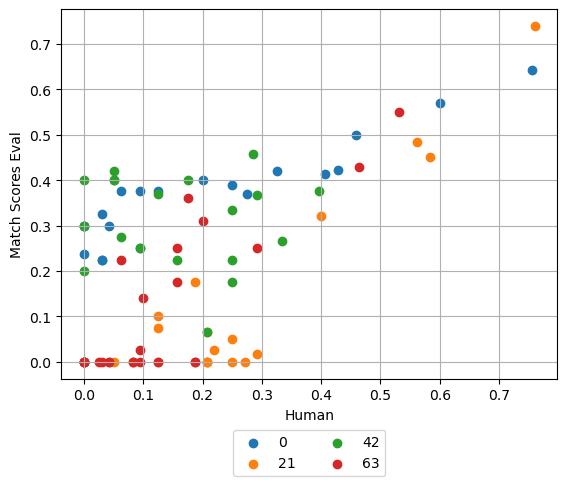

In [ ]:
i = 0
for i in range(0,84,21):
    plt.scatter(np.mean([benjamin_red, johannes_red, steffen_red, moritz_red], axis = 0)[i:i+21], np.mean(scores_llm_5, axis = 0)[i:i+21], label = f'{i}')
plt.xlabel('Human')
plt.ylabel('Match Scores Eval')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol = 2)
plt.grid()
plt.show()